# Figure 2

This notebook loads the data and produces figure 2. The intermediate files "figure2_maps.csv" and "figure2_line.csv" are saved here and reloaded to be used for the figure. You can reproduce the figure starting from that point in the code by downloading the files from our data repository. You will need to separately download the shape files https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2024.html.

In [1]:
savedate = '20251031'

In [2]:
data_path = '' # path to data - not needed for you to rerun figure
geodata_path = '' # save the shape file folders here
figure_data_path = '' # save the data from the data repository here in a subfolder called "FigureData"
figure_path = '' # path to the Figures folder

In [3]:
import pandas as pd
import geopandas as geopd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
import numpy as np
import state_name_crs_mappings_ML as crsm
pd.options.mode.chained_assignment = None 

# Load map and data

In [4]:
# Load BG-level data
df_bg_level = pd.read_csv(data_path + '23_level_BG_US_imputedquantiles_20250722.zip',dtype={'GEOID':str,'STATEFP':str,'COUNTYFP':str,'BGFIPS':str},index_col=0)
df_bg_level['STATEFP'] = df_bg_level['STATEFP'].str.zfill(2)
df_bg_level['COUNTYFP'] = df_bg_level['COUNTYFP'].str.zfill(5)

# Calculate county-level income quantiles
df1 = df_bg_level[df_bg_level['COUNTYFP']== '06037'].copy()
df1['income_quantile_bg_cty'] = pd.qcut(df1['median_household_income_byBG'], q=5, labels=np.arange(1, 6))
df1['income_quantile_bg_cty_imputed'] = pd.qcut(df1['median_household_income_imputed'], q=5, labels=np.arange(1, 6))

df2 = df_bg_level[df_bg_level['COUNTYFP']== '06059'].copy()
df2['income_quantile_bg_cty'] = pd.qcut(df2['median_household_income_byBG'], q=5, labels=np.arange(1, 6))
df2['income_quantile_bg_cty_imputed'] = pd.qcut(df2['median_household_income_imputed'], q=5, labels=np.arange(1, 6))

df_bg_la = pd.concat((df1, df2), axis=0)
df_bg_la = df_bg_la.reset_index().rename(columns={'BGFP':'BGFIPS'})

In [5]:
# Load BG map (California only)
file_bg = geodata_path + 'tl_bg/tl_2020_06_bg/tl_2020_06_bg.shp'
gdf_bg = geopd.read_file(file_bg)[['GEOID','STATEFP','COUNTYFP','geometry']]
crs = int(crsm.state_to_crs(crsm.abbrev_to_state('MS')).split(':')[1])
gdf_bg = gdf_bg.to_crs(epsg=crs)
gdf_bg['BGFIPS'] = gdf_bg['GEOID']
gdf_bg.set_index('GEOID',inplace=True)

# Zoom in to LA
gdf_bg['STATECOUNTYFP'] = gdf_bg['STATEFP'] + gdf_bg['COUNTYFP']
gdf_bg['BGFIPS'] = gdf_bg['BGFIPS'].astype(int)
gdf_bg = gdf_bg.merge(df_bg_level.reset_index().rename(columns={'BGFP':'BGFIPS'}).loc[:, ['BGFIPS', 'income_quantile_bg_state', 'no_stations','no_PoI']], on='BGFIPS')
gdf_bg_la = gdf_bg[gdf_bg['STATECOUNTYFP'].isin(['06037', '06059'])]

# Merge with station and income data
gdf_bg_la = gdf_bg_la.merge(df_bg_la.loc[:, ['BGFIPS', 'income_quantile_bg_cty', 'income_quantile_bg_cty_imputed', 'income_quantile_bg_state', 'income_quantile_bg_state_imputed']], on='BGFIPS') # 'median_household_income_byBG'
gdf_bg_la['stations_clippedat10'] = np.clip(gdf_bg_la['no_stations'], 0, 10)

## Save and reload 
Then the following plotting script can be run by anyone using the posted data.

In [6]:
# Save necessary columns
gdf_bg_la.loc[:, ['BGFIPS', 
                  'income_quantile_bg_cty_imputed', 
                  'stations_clippedat10']].to_csv(figure_data_path + 'FigureData/figure2_maps.csv')
df_bg_level.loc[:, ['BGFP', 'COUNTYFP', 
                    'median_household_income_imputed', 
                    'no_PoI', 
                    'no_stations']].to_csv(figure_data_path + 'FigureData/figure2_line.csv')

In [7]:
# Reload
bg_la = pd.read_csv(figure_data_path + 'FigureData/figure2_maps.csv', index_col=0)
df_bg_level = pd.read_csv(figure_data_path + 'FigureData/figure2_line.csv', index_col=0, dtype={'BGFP':'str', 'COUNTYFP':'str'})

# Reload map shapefile
file_bg = geodata_path + 'tl_bg/tl_2020_06_bg/tl_2020_06_bg.shp'
gdf_bg = geopd.read_file(file_bg)[['GEOID','STATEFP','COUNTYFP','geometry']]
crs = int(crsm.state_to_crs(crsm.abbrev_to_state('MS')).split(':')[1])
gdf_bg = gdf_bg.to_crs(epsg=crs)
gdf_bg['BGFIPS'] = gdf_bg['GEOID']
gdf_bg.set_index('GEOID',inplace=True)
# Zoom in to LA
gdf_bg['STATECOUNTYFP'] = gdf_bg['STATEFP'] + gdf_bg['COUNTYFP']
gdf_bg['BGFIPS'] = gdf_bg['BGFIPS'].astype(int)

# Merge reloaded data with map
gdf_bg = gdf_bg.merge(bg_la, on='BGFIPS')
gdf_bg_la = gdf_bg[gdf_bg['STATECOUNTYFP'].isin(['06037', '06059'])]


# Figure 2

/var/folders/x0/47mhggk13ms4ct1vkkn6b88r0000gs/T/ipykernel_36003/1585929190.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  gdf_bg_la.loc[inds, 'bg_cty_rel_income_quintile_int_imputed'] = str(int(i))


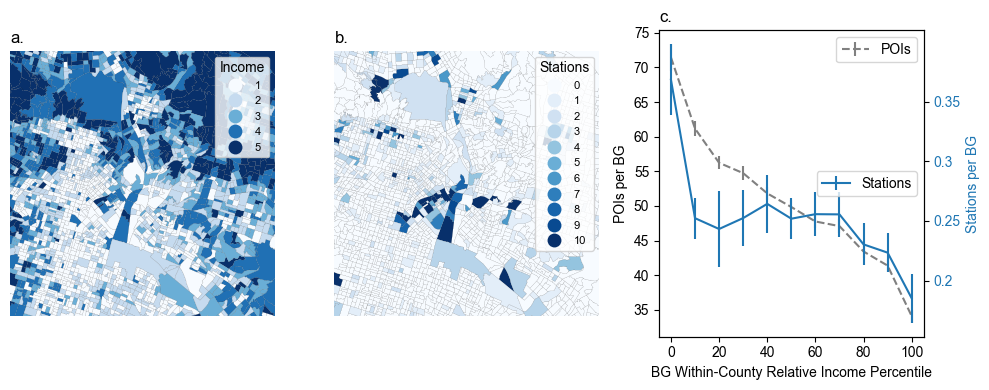

In [8]:
xlims=[-2.47e6, -2.44e6]
ylims=[0.91e6, 0.94e6]
cmap = 'Blues'

fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Convert to strings of whole numbers
gdf_bg_la['bg_cty_rel_income_quintile_int_imputed'] = np.nan
for i in [1,2,3,4,5]:
    inds = gdf_bg_la[gdf_bg_la['income_quantile_bg_cty_imputed']==i].index
    gdf_bg_la.loc[inds, 'bg_cty_rel_income_quintile_int_imputed'] = str(int(i))

# Plot 2a
gdf_bg_la.plot(column='bg_cty_rel_income_quintile_int_imputed', 
               ax=axes[0],  edgecolor="black", linewidth=0.05, 
               legend=True, cmap=cmap, categorical=True, missing_kwds={'color':'lightgrey', 'label':'n/a'}, legend_kwds={'ncol':1, 'fontsize':8, 'title':'Income'})#, legend_kwds={"shrink":.3}, categorical=True, legend_kwds={'loc': 'right'})#, cmap='viridis')#olor=['C'+str(i) for i in range(6)])

# Plot 2b
gdf_bg_la['stations_clippedat10'] = gdf_bg_la['stations_clippedat10'].astype(int)
gdf_bg_la.plot(ax=axes[1], column='stations_clippedat10', 
               vmin=0, vmax=10, legend=True,  
               edgecolor="black", linewidth=0.05, cmap=cmap, categorical=True, legend_kwds={'ncol':1, 'fontsize':8, 'title':'Stations'})#legend_kwds={"shrink":.3}, 

for i in range(2):
    axes[i].set_xlim(xlims)
    axes[i].set_ylim(ylims)
    axes[i].axis('off')

axes[0].set_title('a.', loc='left')
axes[1].set_title('b.', loc='left')

# Calculate within-county income percentile
df_bg_level['perc_within_county'] = df_bg_level.groupby('COUNTYFP')['median_household_income_imputed'].rank(pct=True)
df_bg_level['perc_within_county_bunched'] = df_bg_level['perc_within_county'].apply(lambda x: np.round(x,1))

# Plot 2c
axes[2].errorbar(df_bg_level.groupby('perc_within_county_bunched')['no_PoI'].mean().index, 
                 df_bg_level.groupby('perc_within_county_bunched')['no_PoI'].mean().values, fmt='--', 
                 yerr=1.96*df_bg_level.groupby('perc_within_county_bunched')['no_PoI'].sem(), color='grey', label='POIs')
ax2 = axes[2].twinx()
ax2.errorbar(df_bg_level.groupby('perc_within_county_bunched')['no_stations'].mean().index, 
             df_bg_level.groupby('perc_within_county_bunched')['no_stations'].mean().values, 
             yerr=1.96*df_bg_level.groupby('perc_within_county_bunched')['no_stations'].sem(), color='C0', label='Stations')

# Axis labels and legend
axes[2].set_xlabel('BG Within-County Relative Income Percentile')
axes[2].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=[0, 20, 40, 60, 80, 100])
axes[2].set_ylabel('POIs per BG')
ax2.set_ylabel('Stations per BG', color='C0')
axes[2].legend(loc='upper right')
ax2.legend(loc='center right')
axes[2].set_title('c.', loc='left')
ax2.set_yticks([0.2, 0.25, 0.3, 0.35], labels=[0.2, 0.25, 0.3, 0.35], color='C0')

# Save
plt.tight_layout()
plt.savefig(figure_path + 'Figures/Figure2_imputed_sem_'+savedate+'.png', bbox_inches='tight', dpi=1000)
plt.savefig(figure_path + 'Figures/Figure2_imputed_sem_'+savedate+'.pdf', bbox_inches='tight')
plt.show()